# CNN - CIFAR10 - Functionnal API

In [1]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('\033[91m' + 'WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('\033[92m' + 'OK: TensorFlow >= 2.0.0' + '.\033[0m')

2024-05-05 17:57:50.356744: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 17:57:50.935188: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


OK: TensorFlow >= 2.0.0.


**Import libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, 
    Dropout, 
    Flatten, 
    Activation,
    Conv2D, 
    MaxPooling2D, 
    BatchNormalization,
    Input,
    concatenate,
)
from tensorflow.keras import utils
from sklearn.metrics import (
    confusion_matrix,
    multilabel_confusion_matrix, 
    ConfusionMatrixDisplay
)
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


## Data Preparation

**Load and preprocess data**

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)

The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

**Define a function to plot some images from CIFAR and load the dataset.**

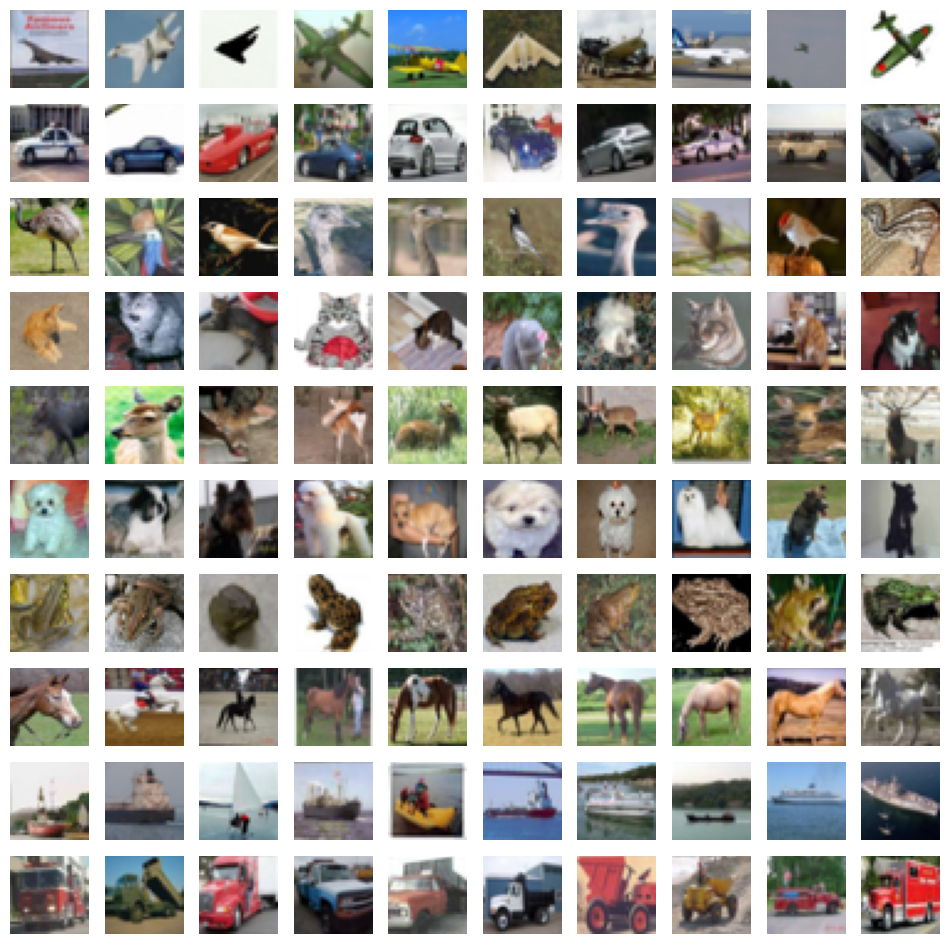

training input shape :  (50000, 32, 32, 3)
training output shape:  (50000, 10)
testing input shape  :  (10000, 32, 32, 3)
testing output shape :  (10000, 10)


In [4]:
def show_imgs(X,y):
    plt.figure(1, figsize=(12,12))
    k = 0
    for i in range(0,10):
        for j in range(0,10):
            while y[k] != i: k += 1
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k += 1
    plt.show()

show_imgs(X_test, y_test)
print('training input shape : ', X_train.shape)
print('training output shape: ', Y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', Y_test.shape)

## Model Building

### Experiment 1

**Sequential API**

In [5]:
def build_exp1_sequential():
    model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)),
    Activation('relu'),
    Conv2D(32, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(n_classes, activation='softmax'),
    ], name='exp1_sequential')
    return model


**Functional API**

In [6]:
def build_exp1_functional():
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='exp1_functional')
    return model




### Experiment 2

In [7]:
def build_exp2_functional():
    visible = Input(shape=(32, 32, 3))
    # first feature extractor
    conv1 = Conv2D(32, kernel_size=3, activation='relu')(visible)
    drop1 = Dropout(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)
    flat1 = Flatten()(pool1)
    # second feature extractor
    conv2 = Conv2D(32, kernel_size=6, activation='relu')(visible)
    drop2 = Dropout(0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    flat2 = Flatten()(pool2)
    # merge feature extractors
    merge = concatenate([flat1, flat2])
    # interpretation layer
    hidden1 = Dense(100, activation='relu')(merge)
    # prediction output
    output = Dense(n_classes, activation='softmax')(hidden1)
    model = Model(inputs=visible, outputs=output, name='exp2_functional')
    return model



### Experiment 3

In [8]:
def build_exp3_functional():
    visible = Input(shape=(32, 32, 3))
    # first feature extractor
    conv1 = Conv2D(32, kernel_size=3, activation='relu')(visible)
    drop1 = Dropout(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)
    flat1 = Flatten()(pool1)
    # second feature extractor
    conv2 = Conv2D(32, kernel_size=3, activation='relu')(pool1)
    drop2 = Dropout(0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    flat2 = Flatten()(pool2)
    # third feature extractor
    conv3 = Conv2D(32, kernel_size=3, activation='relu')(pool2)
    drop3 = Dropout(0.2)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    flat3 = Flatten()(pool3)
    # merge feature extractors
    merge = concatenate([flat1, flat2, flat3])
    # interpretation layer
    hidden1 = Dense(100, activation='relu')(merge)
    # prediction output
    output = Dense(n_classes, activation='softmax')(hidden1)
    model = Model(inputs=visible, outputs=output, name='exp3_functional')
    return model

## Training

**Compile models**

In [9]:
model_exp1_seq = build_exp1_sequential()
model_exp1_seq.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_exp1_func = build_exp1_functional()
model_exp1_func.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_exp2_func = build_exp2_functional()
model_exp2_func.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_exp3_func = build_exp3_functional()
model_exp3_func.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/home/olivier/anaconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-05-05 17:57:54.106923: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 17:57:54.132585: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for y

**Data Augmentation**

Don't forget to reset your network (by defining it again). You need then to compile the network and train it. The call to the `fit()` function has to be replaced by a call to `fit_generator()` and using the data flow defined above. 

In [10]:
datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      shear_range=0.2,        
      zoom_range=0.2,        
      fill_mode='nearest')  

train_generator = datagen.flow(X_train, Y_train, batch_size=128)
test_generator = datagen.flow(X_test, Y_test, batch_size=128)

**Evaluation Plots Function**

In [11]:
def plot(history):
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(history.history['loss'], label='Training loss')
    ax1.plot(history.history['val_loss'], label='Validation loss')
    ax1.legend()
    ax1.grid()

    ax2.plot(history.history['accuracy'], label='Training accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation accuracy')
    ax2.set_title('Accuracy Metrics')
    ax2.legend()
    ax2.grid()
    plt.show()

**Train function**

In [12]:
def train_and_evaluate_with_augmentation(model):
    batch_size = 128
    train_generator = datagen.flow(X_train, Y_train, batch_size=batch_size)
    test_generator = datagen.flow(X_test, Y_test, batch_size=batch_size)

    checkpoint_filepath = model.name + '.keras'

    history = model.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=15,
        validation_data=test_generator,
        validation_steps=10,
        callbacks=[ModelCheckpoint(checkpoint_filepath, save_best_only=True)]
    )
    
    plot(history)

    # Evaluate the model on the test data
    test_loss, test_acc = model.evaluate(X_test, Y_test)
    print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")
    
    return history


**Experiment 1: Sequential Model**

Epoch 1/15


/home/olivier/anaconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.2132 - loss: 2.1137 - val_accuracy: 0.3469 - val_loss: 1.7812
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.3592 - loss: 1.7588 - val_accuracy: 0.3820 - val_loss: 1.6991
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.3918 - loss: 1.6605 - val_accuracy: 0.4430 - val_loss: 1.6068
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.4226 - loss: 1.5891 - val_accuracy: 0.4578 - val_loss: 1.5157
Epoch 5/15


2024-05-05 17:58:27.018469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/olivier/anaconda3/envs/tensorflow/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.4452 - loss: 1.5359 - val_accuracy: 0.4578 - val_loss: 1.5309
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.4626 - loss: 1.4817 - val_accuracy: 0.4875 - val_loss: 1.4710
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.4832 - loss: 1.4398 - val_accuracy: 0.4961 - val_loss: 1.3991
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.4971 - loss: 1.4007 - val_accuracy: 0.5173 - val_loss: 1.3608
Epoch 9/15


2024-05-05 17:58:58.403965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 17:58:58.477832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5092 - loss: 1.3749 - val_accuracy: 0.5344 - val_loss: 1.3006
Epoch 10/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.5182 - loss: 1.3430 - val_accuracy: 0.5328 - val_loss: 1.2934
Epoch 11/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5350 - loss: 1.2801 - val_accuracy: 0.5422 - val_loss: 1.2685
Epoch 12/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5355 - loss: 1.3031 - val_accuracy: 0.5516 - val_loss: 1.2397
Epoch 13/15


2024-05-05 17:59:29.740355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5452 - loss: 1.2504 - val_accuracy: 0.5578 - val_loss: 1.2277
Epoch 14/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.5453 - loss: 1.2541 - val_accuracy: 0.5523 - val_loss: 1.2249
Epoch 15/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.5651 - loss: 1.2241 - val_accuracy: 0.5562 - val_loss: 1.2020


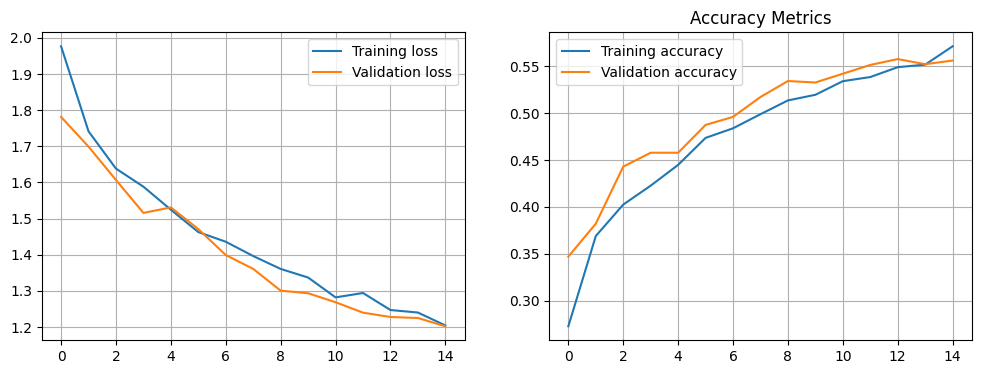

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6089 - loss: 1.1090
Test Accuracy: 0.6071000099182129, Test Loss: 1.1107553243637085


In [13]:
hist_1_seq = train_and_evaluate_with_augmentation(model_exp1_seq)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.2273 - loss: 2.0847 - val_accuracy: 0.3633 - val_loss: 1.7473
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.3785 - loss: 1.7347 - val_accuracy: 0.4000 - val_loss: 1.6729
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.3976 - loss: 1.6336 - val_accuracy: 0.4523 - val_loss: 1.5478
Epoch 4/15
 91/100 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.4312 - loss: 1.5661

2024-05-05 18:00:32.249404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.4320 - loss: 1.5638 - val_accuracy: 0.4609 - val_loss: 1.4538
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.4565 - loss: 1.5207 - val_accuracy: 0.4992 - val_loss: 1.3855
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.4857 - loss: 1.4337 - val_accuracy: 0.5047 - val_loss: 1.3936
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.4851 - loss: 1.4257 - val_accuracy: 0.5023 - val_loss: 1.3747
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5000 - loss: 1.3859 - val_accuracy: 0.5058 - val_loss: 1.2921
Epoch 9/15


2024-05-05 18:01:20.033258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 18:01:20.108388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5157 - loss: 1.3549 - val_accuracy: 0.5203 - val_loss: 1.3446
Epoch 10/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5207 - loss: 1.3223 - val_accuracy: 0.5320 - val_loss: 1.2585
Epoch 11/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5412 - loss: 1.3029 - val_accuracy: 0.5266 - val_loss: 1.3172
Epoch 12/15
 91/100 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.5371 - loss: 1.2942

2024-05-05 18:01:56.530118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.5379 - loss: 1.2921 - val_accuracy: 0.5547 - val_loss: 1.2653
Epoch 13/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - accuracy: 0.5543 - loss: 1.2408 - val_accuracy: 0.5672 - val_loss: 1.2259
Epoch 14/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.5431 - loss: 1.2570 - val_accuracy: 0.5562 - val_loss: 1.2060
Epoch 15/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.5695 - loss: 1.2029 - val_accuracy: 0.5688 - val_loss: 1.1995


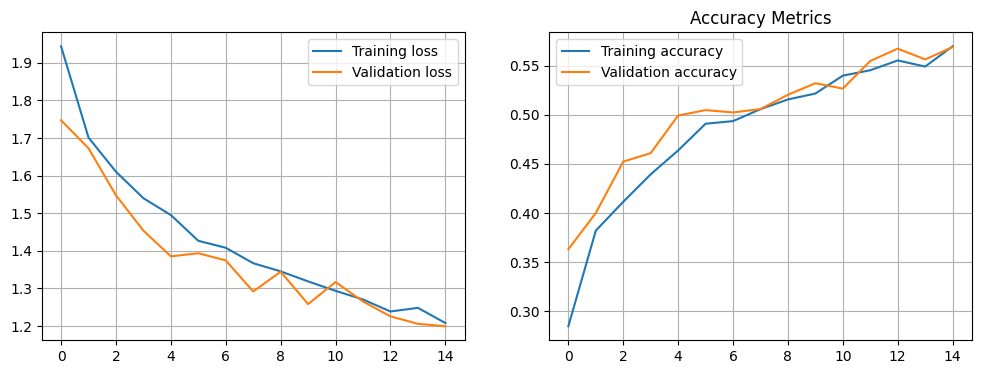

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6171 - loss: 1.0924
Test Accuracy: 0.6187999844551086, Test Loss: 1.0867677927017212


In [14]:
hist_1_func = train_and_evaluate_with_augmentation(model_exp1_func)


**Experiment 2: Functional API**

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.1574 - loss: 2.3329 - val_accuracy: 0.2750 - val_loss: 2.0009
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.2867 - loss: 1.9507 - val_accuracy: 0.3344 - val_loss: 1.8699
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.3323 - loss: 1.8407 - val_accuracy: 0.3391 - val_loss: 1.7926
Epoch 4/15
 91/100 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.3624 - loss: 1.7612

2024-05-05 18:04:21.860481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.3630 - loss: 1.7594 - val_accuracy: 0.3617 - val_loss: 1.7486
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.3762 - loss: 1.7217 - val_accuracy: 0.3883 - val_loss: 1.6941
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.3821 - loss: 1.6935 - val_accuracy: 0.3992 - val_loss: 1.6794
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.4101 - loss: 1.6400 - val_accuracy: 0.4055 - val_loss: 1.6418
Epoch 8/15
 91/100 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.4152 - loss: 1.6156

2024-05-05 18:05:14.232468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 18:05:14.402944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.4155 - loss: 1.6146 - val_accuracy: 0.4298 - val_loss: 1.5981
Epoch 9/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.4338 - loss: 1.5765 - val_accuracy: 0.4414 - val_loss: 1.5724
Epoch 10/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.4384 - loss: 1.5523 - val_accuracy: 0.4398 - val_loss: 1.5923
Epoch 11/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.4376 - loss: 1.5575 - val_accuracy: 0.4492 - val_loss: 1.5355
Epoch 12/15
 91/100 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.4335 - loss: 1.5563

2024-05-05 18:06:02.903856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.4339 - loss: 1.5565 - val_accuracy: 0.4227 - val_loss: 1.5902
Epoch 13/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.4481 - loss: 1.5506 - val_accuracy: 0.4352 - val_loss: 1.5810
Epoch 14/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.4380 - loss: 1.5621 - val_accuracy: 0.4719 - val_loss: 1.4914
Epoch 15/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.4539 - loss: 1.5217 - val_accuracy: 0.4680 - val_loss: 1.5208


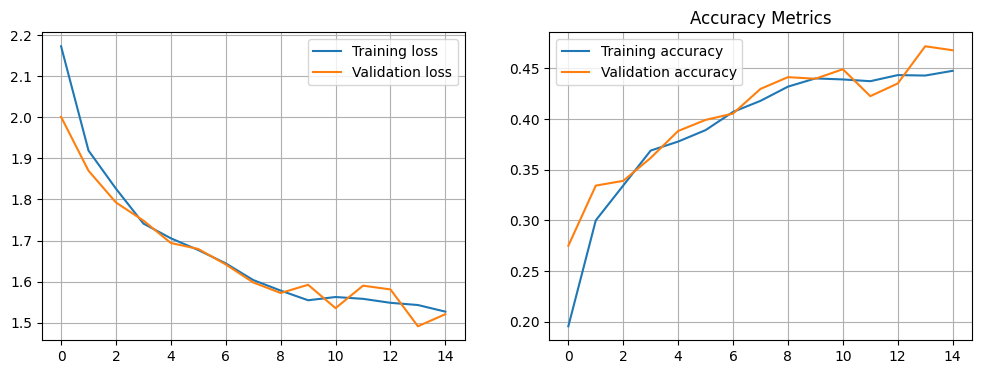

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5137 - loss: 1.3885
Test Accuracy: 0.5116000175476074, Test Loss: 1.3925127983093262


In [16]:
hist_2_func = train_and_evaluate_with_augmentation(model_exp2_func)

**Experiment 3: Functional API with Data Augmentation**

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2190 - loss: 2.1421 - val_accuracy: 0.3313 - val_loss: 1.8637
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.3570 - loss: 1.7658 - val_accuracy: 0.3852 - val_loss: 1.7349
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.3986 - loss: 1.6766 - val_accuracy: 0.4102 - val_loss: 1.6165
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.4146 - loss: 1.6196 - val_accuracy: 0.4445 - val_loss: 1.5781
Epoch 5/15


2024-05-05 18:07:17.030253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.4363 - loss: 1.5815 - val_accuracy: 0.4391 - val_loss: 1.5726
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.4456 - loss: 1.5413 - val_accuracy: 0.4273 - val_loss: 1.5588
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.4551 - loss: 1.5263 - val_accuracy: 0.4758 - val_loss: 1.5134
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.4820 - loss: 1.4583 - val_accuracy: 0.5087 - val_loss: 1.4231
Epoch 9/15


2024-05-05 18:07:39.987516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 18:07:40.027585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.4819 - loss: 1.4495 - val_accuracy: 0.4469 - val_loss: 1.5030
Epoch 10/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.4899 - loss: 1.4307 - val_accuracy: 0.4594 - val_loss: 1.4809
Epoch 11/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.4890 - loss: 1.4108 - val_accuracy: 0.4711 - val_loss: 1.4380
Epoch 12/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5128 - loss: 1.3806 - val_accuracy: 0.4727 - val_loss: 1.4717
Epoch 13/15


2024-05-05 18:08:02.685092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.5073 - loss: 1.3886 - val_accuracy: 0.5109 - val_loss: 1.4145
Epoch 14/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.5118 - loss: 1.3807 - val_accuracy: 0.4984 - val_loss: 1.3914
Epoch 15/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.5119 - loss: 1.3876 - val_accuracy: 0.4883 - val_loss: 1.4035


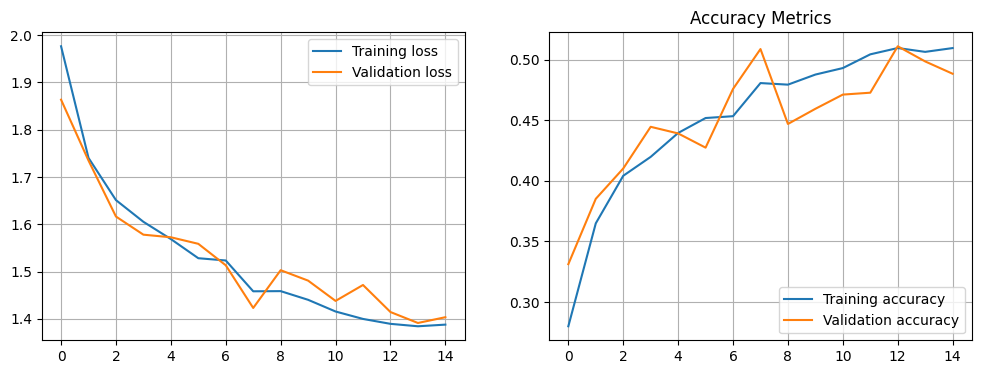

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5381 - loss: 1.2982
Test Accuracy: 0.5307000279426575, Test Loss: 1.3036366701126099


In [17]:
hist_3_func = train_and_evaluate_with_augmentation(model_exp3_func)

## Final Results

In [20]:
train_acc = {}
val_acc = {}
test_acc = {}  # Dictionary to store test accuracies

def get_acc(model, history):
    train_acc[model.name] = history.history['accuracy'][-1]  # Store last training accuracy
    val_acc[model.name] = history.history['val_accuracy'][-1]  # Store last validation accuracy
    test_loss, test_accuracy = model.evaluate(X_test, Y_test)  # Evaluate the model
    test_acc[model.name] = test_accuracy  # Correctly assign the test accuracy to the dictionary

# Call the function for each model and history
get_acc(model_exp1_seq, hist_1_seq)
get_acc(model_exp1_func, hist_1_func)
get_acc(model_exp2_func, hist_2_func)
get_acc(model_exp3_func, hist_3_func)

# Print the dictionaries containing accuracies
print(train_acc)
print(val_acc)
print(test_acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6089 - loss: 1.1090
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6171 - loss: 1.0924
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5137 - loss: 1.3885
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5381 - loss: 1.2982
{'exp1_sequential': 0.571484386920929, 'exp1_functional': 0.5696094036102295, 'exp2_functional': 0.4476562440395355, 'exp3_functional': 0.5094531178474426}
{'exp1_sequential': 0.5562499761581421, 'exp1_functional': 0.5687500238418579, 'exp2_functional': 0.46796876192092896, 'exp3_functional': 0.48828125}
{'exp1_sequential': 0.6071000099182129, 'exp1_functional': 0.6187999844551086, 'exp2_functional': 0.5116000175476074, 'exp3_functional': 0.5307000279426575}
